In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import sqlite3
from pandasql import sqldf
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# load in data sets
boxoffice = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_table('zippedData/rt.movie_info.tsv.gz')
reviews = pd.read_table('zippedData/rt.reviews.tsv.gz', encoding='windows-1252')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', index_col=0)
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', index_col=0)

# connect to database
conn = sqlite3.connect('zippedData/im.db')

pysqldf = lambda q: sqldf(q, globals())

In [2]:
# join "movie_basics" and "movie_ratings" data
joined = pd.read_sql(
    """SELECT * 
    FROM movie_basics mb 
     JOIN movie_ratings mr 
      ON mb.movie_id=mr.movie_id 
     JOIN directors d 
      ON mb.movie_id = d.movie_id 
     JOIN persons p 
       ON d.person_id = p.person_id;""", conn)

# join "movie_budgets" and "movies" data with "joined" data above
q = """SELECT * FROM joined j JOIN movie_budgets mb ON mb.movie=j.primary_title JOIN movies m ON m.original_title=j.original_title"""
master_df = pysqldf(q).drop_duplicates(subset='primary_title', keep='first')

In [3]:
# drop unneccessary columns
new_master_df = master_df.drop(["original_title", "id", "start_year", "movie", "title", "genre_ids", "original_language", "birth_year", "death_year", 'release_date'], axis=1)

# rename "duplicate" columns to reflect data source
new_master_df = new_master_df.rename(columns={"vote_average": "tmdb_vote_average",
                                              "vote_count": "tmdb_vote_count", 
                                              "averagerating": "imdb_average_rating", 
                                              "numvotes": "imdb_vote_count"})

# convert the "genres" and "primary_profession" column into a list
new_master_df["genres"] = new_master_df["genres"].str.split(',')
new_master_df["primary_profession"] = new_master_df["primary_profession"].str.split(',')
new_master_df

# convert "domestic_gross", "production_budget", "worldwide_gross" to integers 
new_master_df['domestic_gross'] = new_master_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['production_budget'] = new_master_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['worldwide_gross'] = new_master_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(int)
final_master_df = new_master_df
final_master_df

# calculate "domestic_profit" and "worldwide_profit" by subtracting "production_budget" from "domestic_gross" and "worldwide_gross"
final_master_df['domestic_profit'] = final_master_df['domestic_gross'] - final_master_df['production_budget']
final_master_df['worldwide_profit'] = final_master_df['worldwide_gross'] - final_master_df['production_budget']
final_master_df.head(3)

C:\Users\rvanjani\AppData\Local\Temp\ipykernel_16692\245131667.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_master_df['domestic_gross'] = new_master_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
C:\Users\rvanjani\AppData\Local\Temp\ipykernel_16692\245131667.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_master_df['production_budget'] = new_master_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
C:\Users\rvanjani\AppData\Local\Temp\ipykernel_16692\245131667.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expr

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,person_id,primary_name,primary_profession,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
0,tt0249516,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
5,tt0326592,The Overnight,88.0,None,7.5,24,nm1208371,Jed I. Goodman,"[camera_department, writer, producer]",200000,1109808,1165996,6.576,6.0,200,909808,965996
7,tt0337692,On the Road,124.0,"[Adventure, Drama, Romance]",6.1,37886,nm0758574,Walter Salles,"[director, producer, writer]",25000000,720828,9313302,8.919,5.6,518,-24279172,-15686698


In [4]:
# correlation between "popularity" and "worldwide_profit"
popularity_correlation = final_master_df['popularity'].corr(final_master_df['worldwide_profit'])
popularity_correlation

0.5973826421033719

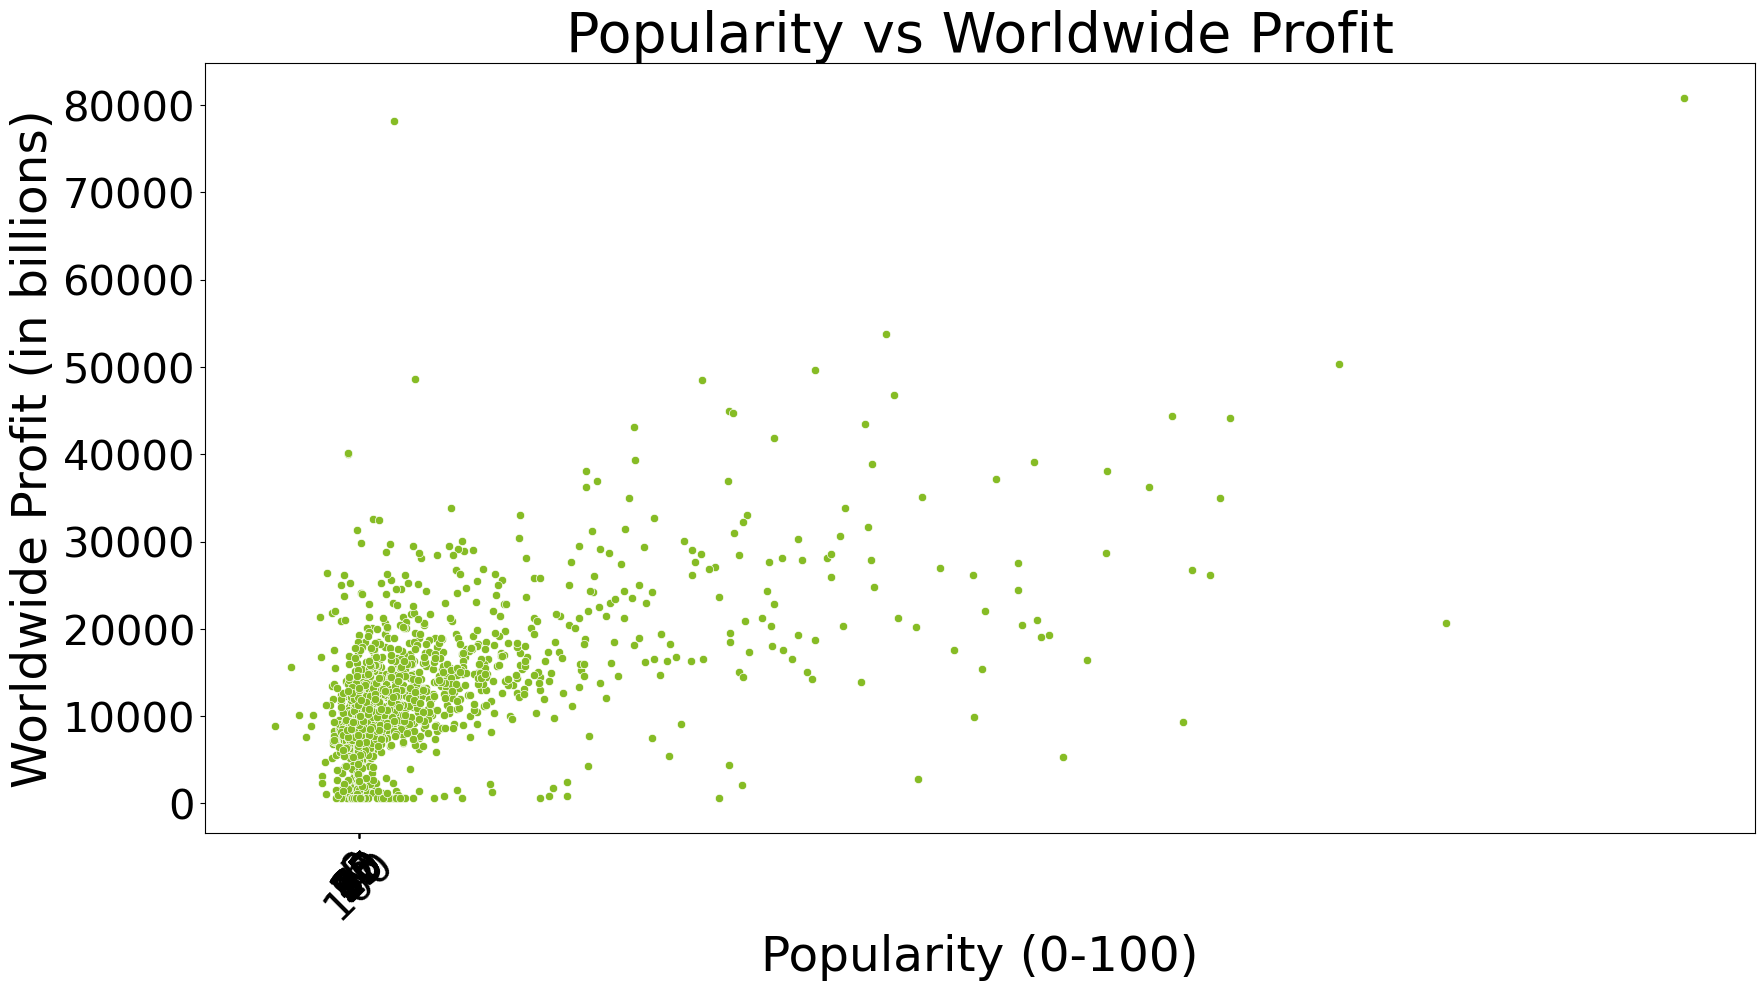

In [26]:
# scatterplot showing the relationship between "popularity" and "worldwide_profit"
plt.figure(figsize=(20, 10))
sns.scatterplot(y=final_master_df['popularity'], 
                x=final_master_df['worldwide_profit'], color="#86BC25")

# set barplot title and axes labels
plt.title(label = "Popularity vs Worldwide Profit", fontsize=40)
plt.xlabel("Popularity (0-100)", fontsize=35)
plt.ylabel("Worldwide Profit (in billions)", fontsize=35)

# set x and y tick size
plt.xticks(range(0, 101, 5), size = 30, rotation=45)
plt.yticks(size = 30)
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False);

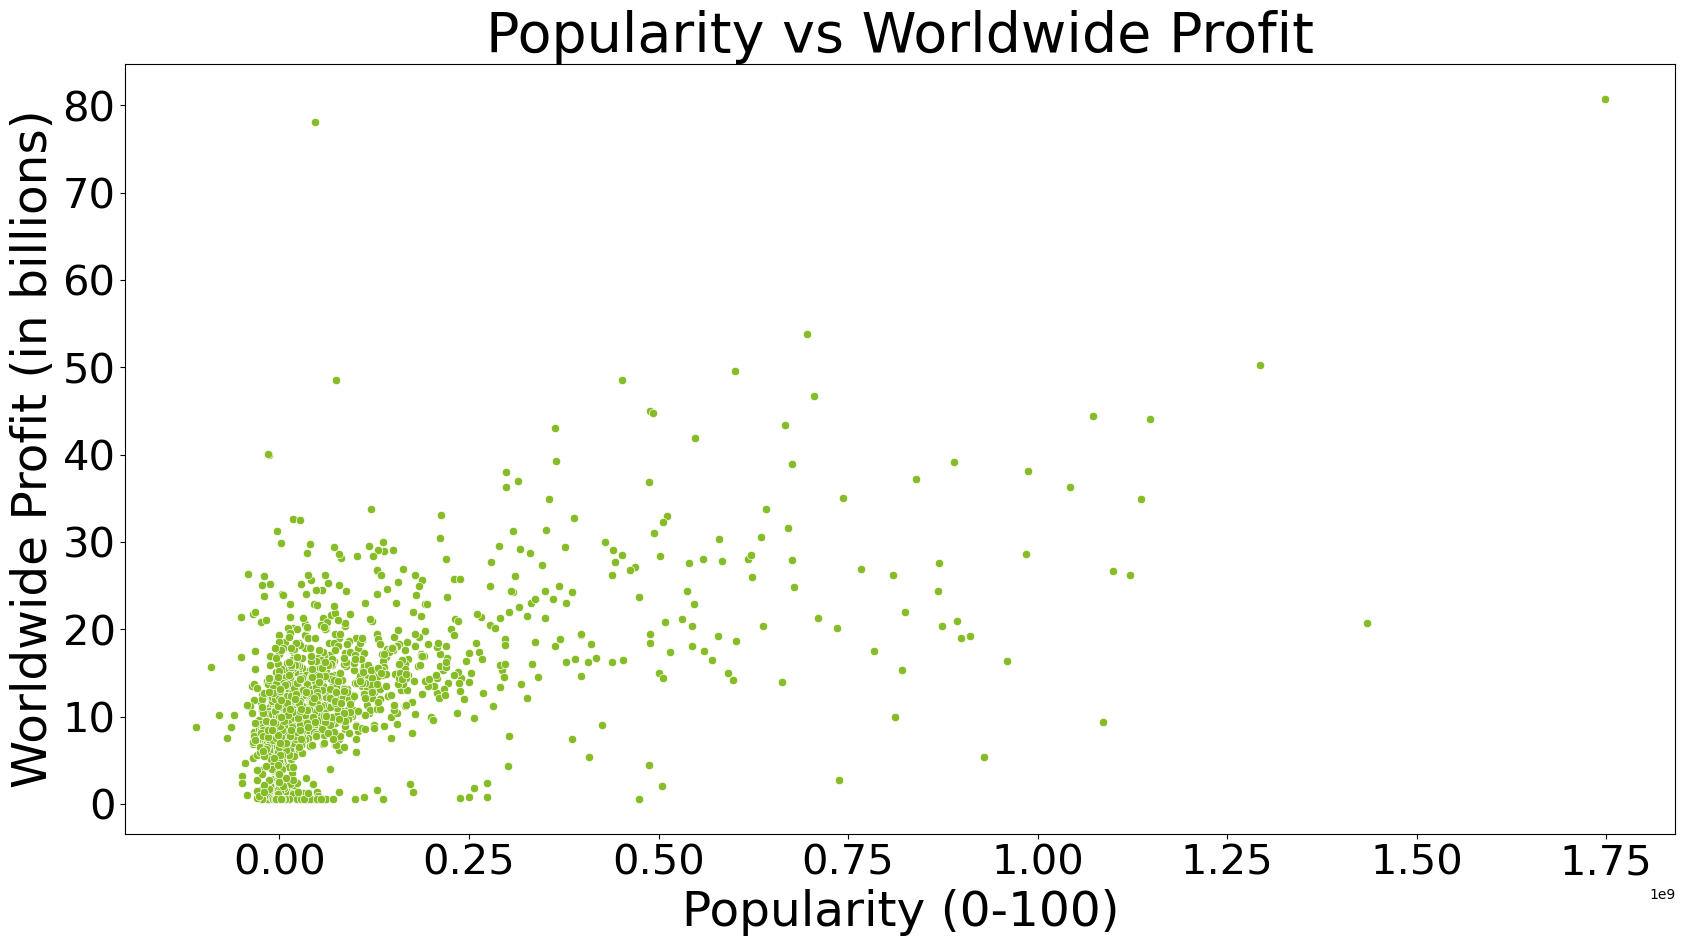

In [21]:
# scatterplot showing the relationship between "popularity" and "worldwide_profit"
plt.figure(figsize=(20, 10))
sns.scatterplot(y=final_master_df['popularity'], 
                x=final_master_df['worldwide_profit'], color="#86BC25")

# set barplot title and axes labels
plt.title(label = "Popularity vs Worldwide Profit", fontsize=40)
plt.xlabel("Popularity (0-100)", fontsize=35)
plt.ylabel("Worldwide Profit (in billions)", fontsize=35)

# set x and y tick size
plt.xticks(size = 30)
plt.yticks(size = 30);

(600.0, 80773.0)

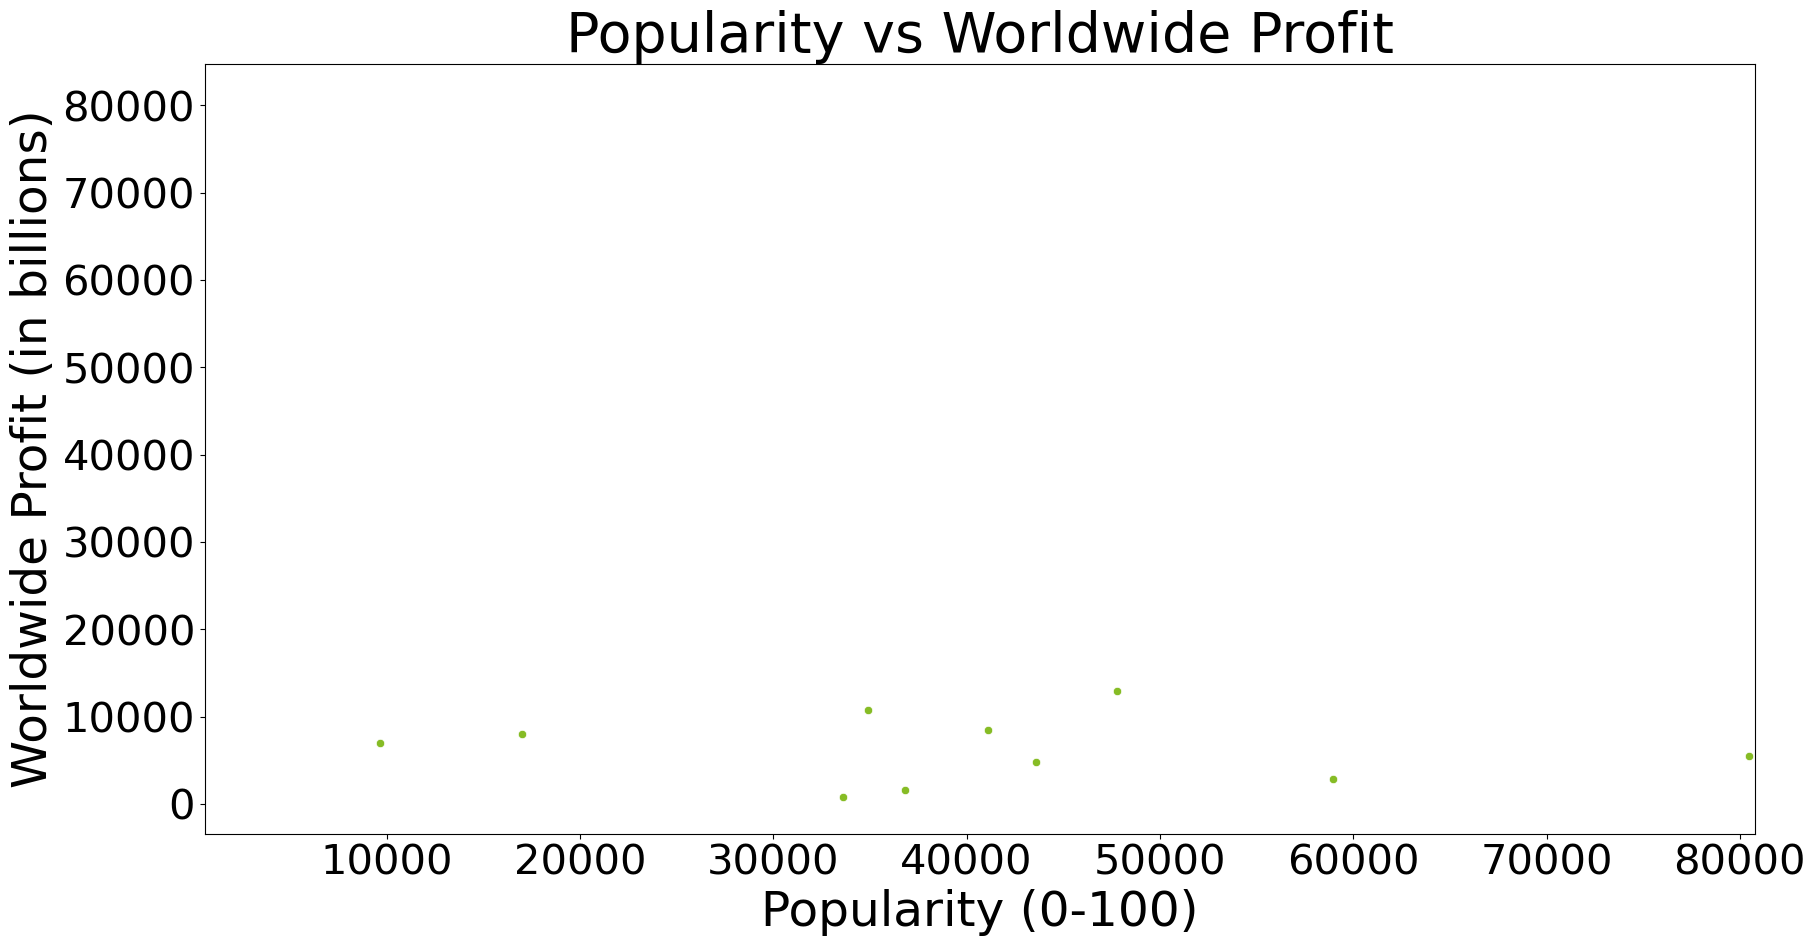

In [25]:
# scatterplot showing the relationship between "popularity" and "worldwide_profit"

plt.figure(figsize=(20, 10))
sns.scatterplot(y=final_master_df['popularity'], 
                x=final_master_df['worldwide_profit'], color="#86BC25")

# set barplot title and axes labels
plt.title(label = "Popularity vs Worldwide Profit", fontsize=40)
plt.xlabel("Popularity (0-100)", fontsize=35)
plt.ylabel("Worldwide Profit (in billions)", fontsize=35)

# set x and y tick size
plt.xticks(size = 30)
plt.yticks(size = 30)
popularity_min = final_master_df['popularity'].min()
popularity_max = final_master_df['popularity'].max()

plt.xlim(popularity_min,popularity_max)